<a href="https://colab.research.google.com/github/basselkassem/predict_income_potential/blob/master/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = "/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/data/"
model_path = '/content/gdrive/My Drive/Colab Notebooks/predict_income_potential/models/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import libs

In [0]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [3]:
cont_cat_lb = pd.read_pickle(data_path + 'data_cont_cat_lb.pkl')
cont_cat_oh = pd.read_pickle(data_path + 'data_cont_cat_oh.pkl')
bin_lb_cat_lb = pd.read_pickle(data_path + 'data_bin_lb_cat_lb.pkl')
bin_oh_cat_oh = pd.read_pickle(data_path + 'data_bin_oh_cat_oh.pkl')

print('continuous_categorical_label shape: ', cont_cat_lb.shape)
print('continuous_categorical_one_hot shape: ', cont_cat_oh.shape)
print('bin_label_categorical_label shape: ', bin_lb_cat_lb.shape)
print('bin_one_hot_categorical_one_hot shape: ', bin_oh_cat_oh.shape)

continuous_categorical_label shape:  (48813, 39)
continuous_categorical_one_hot shape:  (48813, 134)
bin_label_categorical_label shape:  (48813, 39)
bin_one_hot_categorical_one_hot shape:  (48813, 660)


# Utile Function

In [0]:
def evaluate_test_model(X, y, verbose = True):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  gbm = lgb.LGBMClassifier(n_estimators = 1000, silent = True)
  gbm.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds = 10, verbose = 0)

  y_train_hat = gbm.predict(X_train)
  y_test_hat = gbm.predict(X_test)

  tr_acc = accuracy_score(y_train, y_train_hat)
  tr_f1 = f1_score(y_train, y_train_hat)
  tr_auc = roc_auc_score(y_train, y_train_hat)

  test_acc = accuracy_score(y_test, y_test_hat)
  test_f1 = f1_score(y_test, y_test_hat)
  test_auc = roc_auc_score(y_test, y_test_hat)
  if verbose:
    print('------train-----------')
    print('accuracy_score: ', tr_acc)
    print('f1_score: ', tr_f1)
    print('roc_auc_score: ', tr_auc)
    print('------test-------------')
    print('accuracy_score: ', test_acc)
    print('f1_score: ', test_f1)
    print('roc_auc_score: ', test_auc)
  return [test_acc, test_f1, test_auc]

# Test data encoding

## Continuous Feature Vs Binnig

### Contiuous Featrue

In [6]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']
res = evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8895242172211351
f1_score:  0.7464739316539191
roc_auc_score:  0.8187277910967594
------test-------------
accuracy_score:  0.8741697187907381
f1_score:  0.7166223961973996
roc_auc_score:  0.8001044450907345


### Binned Features



In [9]:
data = bin_lb_cat_lb
X, y = data.drop(columns = 'target'), data['target']
res = evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.879005626223092
f1_score:  0.7229961498074904
roc_auc_score:  0.8049748252683014
------test-------------
accuracy_score:  0.8654789248246322
f1_score:  0.6983994432846207
roc_auc_score:  0.789666797603355


## Label encoding Vs One-hot encoding

### One-hot encoding

In [11]:
data = cont_cat_oh
X, y = data.drop(columns = 'target'), data['target']
res = evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.886619373776908
f1_score:  0.7401177460050462
roc_auc_score:  0.8150979491793872
------test-------------
accuracy_score:  0.8751629523868645
f1_score:  0.7187019163519374
roc_auc_score:  0.8012823926665382


### Label Encoding

In [12]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']
res = evaluate_test_model(X, y)

------train-----------
accuracy_score:  0.8895242172211351
f1_score:  0.7464739316539191
roc_auc_score:  0.8187277910967594
------test-------------
accuracy_score:  0.8741697187907381
f1_score:  0.7166223961973996
roc_auc_score:  0.8001044450907345


# Test reducing data dimensionality

In [13]:
data = bin_oh_cat_oh
print(data.shape)
max_pranciple_component = 100

(48813, 660)


In [14]:
result = []
for component_num in range(2, max_pranciple_component):
  pca = PCA(component_num)
  X, y = data.drop(columns = 'target'), data['target']
  projected_X = pca.fit_transform(X)
  print('Reducing data dimension to: ',  component_num)
  res = evaluate_test_model(projected_X, y, False)
  result.append(res)


Reducing data dimension to:  2
Reducing data dimension to:  3
Reducing data dimension to:  4
Reducing data dimension to:  5
Reducing data dimension to:  6
Reducing data dimension to:  7
Reducing data dimension to:  8
Reducing data dimension to:  9
Reducing data dimension to:  10
Reducing data dimension to:  11
Reducing data dimension to:  12
Reducing data dimension to:  13
Reducing data dimension to:  14
Reducing data dimension to:  15
Reducing data dimension to:  16
Reducing data dimension to:  17
Reducing data dimension to:  18
Reducing data dimension to:  19
Reducing data dimension to:  20
Reducing data dimension to:  21
Reducing data dimension to:  22
Reducing data dimension to:  23
Reducing data dimension to:  24
Reducing data dimension to:  25
Reducing data dimension to:  26
Reducing data dimension to:  27
Reducing data dimension to:  28
Reducing data dimension to:  29
Reducing data dimension to:  30
Reducing data dimension to:  31
Reducing data dimension to:  32
Reducing data di

In [0]:
result = np.array(result)

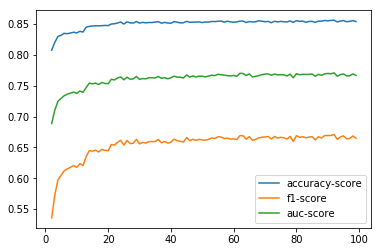

In [18]:
acc = result[:, 0]
f1 = result[:, 1]
auc = result[:, 2]
x = np.arange(2, max_pranciple_component)
plt.plot(x, acc, label = 'accuracy-score')
plt.plot(x, f1, label = 'f1-score')
plt.plot(x, auc, label = 'auc-score')
plt.legend()
plt.show()

## Results:
Keeping the continuous features without binning and encoding the categorical features with label_ecoding gave the best results (accuracy, f1-score, auc-score).


# Feature Selection

In [0]:
data = cont_cat_lb
X, y = data.drop(columns = 'target'), data['target']

## Determine the optimal number of features

In [0]:
features_number = np.arange(1, data.shape[1])            
high_score = 0
feature_number = 0           
score_list =[]
for n in range(len(features_number)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    model = lgb.LGBMClassifier(n_estimators = 2000, silent = True)
    rfe = RFE(model, features_number[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train, eval_set = [(X_test_rfe, y_test)], early_stopping_rounds = 10, verbose = 0)
    score = model.score(X_test_rfe, y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        feature_number = features_number[n]

print("Optimum number of features: %d" %feature_number)
print("Score with %d features: %f" % (feature_number, high_score))

Optimum number of features: 31
Score with 31 features: 0.874420


## Recursive Feature Elimination

In [0]:
cols = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
model =lgb.LGBMClassifier(n_estimators = 2000, silent = True)
rfe = RFE(model, feature_number)             
X_rfe = rfe.fit_transform(X_train, y)
X_test_rfe = rfe.transform(X_test)
model.fit(X_rfe, y_train, eval_set = [(X_test_rfe, y_test)], early_stopping_rounds = 10, verbose = 0)             
temp = pd.Series(rfe.support_, index = cols)
selected_features_rfe = temp[temp == True].index
print(selected_features_rfe)

Index(['age', 'workclass', 'final_weight', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country', 'age final_weight', 'age education_duration',
       'age hours_per_week', 'age capital_gain', 'age capital_loss',
       'final_weight education_duration', 'final_weight hours_per_week',
       'final_weight capital_gain', 'final_weight capital_loss',
       'education_duration hours_per_week', 'education_duration capital_gain',
       'education_duration capital_loss', 'hours_per_week capital_gain',
       'hours_per_week capital_loss'],
      dtype='object')


In [0]:
features = ['age', 'workclass', 'final_weight', 'education_duration',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'has_missing_values', 'com_workclass', 'com_marital_status',
       'com_native_country', 'age final_weight', 'age education_duration',
       'age hours_per_week', 'age capital_gain', 'age capital_loss',
       'final_weight education_duration', 'final_weight hours_per_week',
       'final_weight capital_gain', 'final_weight capital_loss',
       'education_duration hours_per_week', 'education_duration capital_gain',
       'education_duration capital_loss', 'hours_per_week capital_gain',
       'hours_per_week capital_loss']
np.save(data_path + 'features.pkl', features, allow_pickle = True)